In [7]:
correct = list(range(100))
correct = [correct[j::4] for j in range(4)]
correct

[[0,
  4,
  8,
  12,
  16,
  20,
  24,
  28,
  32,
  36,
  40,
  44,
  48,
  52,
  56,
  60,
  64,
  68,
  72,
  76,
  80,
  84,
  88,
  92,
  96],
 [1,
  5,
  9,
  13,
  17,
  21,
  25,
  29,
  33,
  37,
  41,
  45,
  49,
  53,
  57,
  61,
  65,
  69,
  73,
  77,
  81,
  85,
  89,
  93,
  97],
 [2,
  6,
  10,
  14,
  18,
  22,
  26,
  30,
  34,
  38,
  42,
  46,
  50,
  54,
  58,
  62,
  66,
  70,
  74,
  78,
  82,
  86,
  90,
  94,
  98],
 [3,
  7,
  11,
  15,
  19,
  23,
  27,
  31,
  35,
  39,
  43,
  47,
  51,
  55,
  59,
  63,
  67,
  71,
  75,
  79,
  83,
  87,
  91,
  95,
  99]]

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

matplotlib.rc('font', weight='bold', size=22)

import pandas as pd
import numpy as np

from coind.tickers import streamable, stream_tickers, ticker_sample, stream_batches, batch_sample

In [2]:
import glob

ticker_logs = glob.glob('../data/fresh/stream.*.log')
print(ticker_logs)

['../data/fresh/stream.1.log', '../data/fresh/stream.0.log']


In [3]:
streamable_products = streamable(*ticker_logs)
len(streamable_products), streamable_products

(9,
 ['ETH-USD',
  'BTC-USD',
  'XRP-USD',
  'LTC-USD',
  'BCH-USD',
  'ETC-USD',
  'XLM-USD',
  'ZRX-USD',
  'REP-USD'])

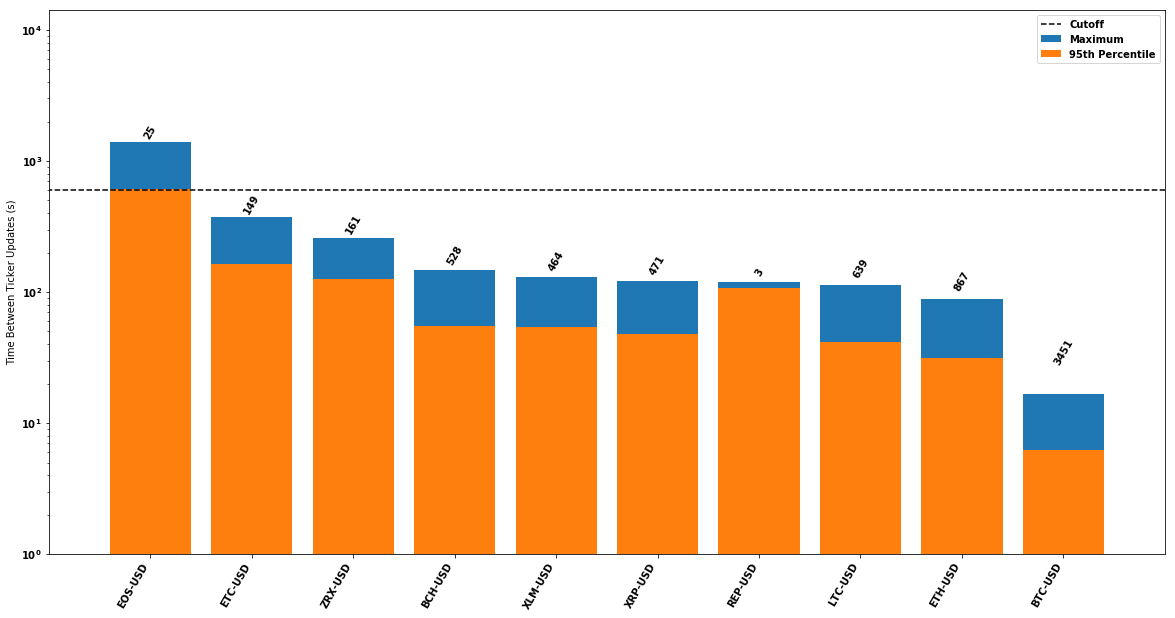

In [4]:
stream = (i for it in (stream_tickers(log) for log in ticker_logs) for i in it)
df = pd.DataFrame.from_records(list(stream), columns=ticker_sample._fields)


cutoff = 600
percentile = 95


deltas = {}
for product in df.product_id.unique():
    product_df = df[df.product_id == product]    
    x = product_df.time
    dts = [(x.iloc[j] - x.iloc[j - 1]).total_seconds() for j in range(1, len(x))]
    deltas[product] = dts
products, deltas = zip(*sorted(deltas.items(), key=(lambda dt: max(dt[1])), reverse=True))


f, ax = plt.subplots(1, 1, figsize=(20, 10))

x = np.arange(len(deltas)) + 0.5
maximums = [max(dts) for dts in deltas]
ax.bar(x, maximums, label='Maximum')
for rect, label in zip(ax.patches, [f'{len(y)}' for y in deltas]):
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 10, label,
            ha='center', va='bottom', rotation=60)
percentiles = [np.percentile(dts, percentile) for dts in deltas]
ax.bar(x, percentiles, label=f'{percentile}th Percentile', width=0.8)

ax.set_xlim((x.min() - 1, x.max() + 1))
ax.set_xticks(x)
ax.set_xticklabels(products, rotation=60, ha='right')
ax.set_ylabel('Time Between Ticker Updates (s)')
ax.set_yscale('log')
ax.set_ylim((1, 10 * max(maximums)))

ax.plot((-10, 100), (cutoff, cutoff), color='k', ls='--', label='Cutoff')
ax.legend()

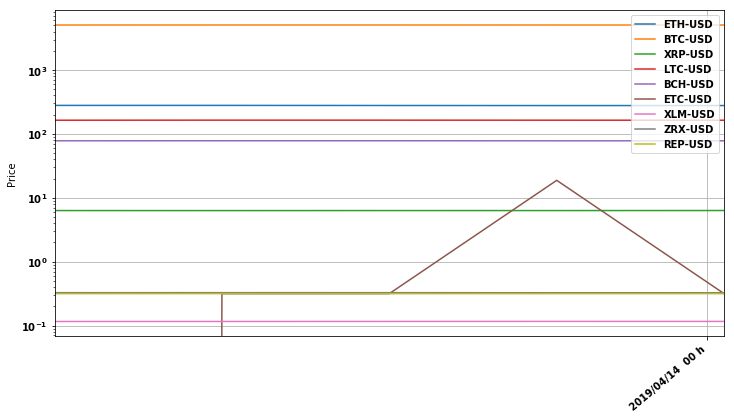

In [5]:
stream = (i for it in (stream_tickers(log, products=streamable_products) for log in ticker_logs) for i in it)
#stream = stream_tickers(*ticker_logs, products=streamable_products)
df = pd.DataFrame.from_records(stream_batches(stream, products=streamable_products),
                               columns=batch_sample._fields)


f, ax = plt.subplots(1, 1, figsize=(12, 6))
for product in streamable_products:
    ax.plot(df.time, df.prices.apply(lambda ps: ps[product]), label=product)
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y/%m/%d  %H h"))
ax.set_xlim((df.time.min(), df.time.max()))
for tick in ax.get_xticklabels():
    tick.set_rotation(40)
    tick.set_ha('right')
ax.grid(True)
ax.set_ylabel('Price')
ax.set_yscale('log')
ax.legend()